In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt


# --- 1. load ---
pcd = o3d.io.read_point_cloud("test1-1.ply")
print(f"Successfully loaded 'test1-1.ply' with {len(pcd.points)} points.")


# --- 2. OBB ---
# This computes the tightest-fitting box around the points.
obb = pcd.get_oriented_bounding_box()


# --- 3. visualize---

obb.color = (0, 1, 0) 

print("\nVisualizing the point cloud with its Oriented Bounding Box (Green).")
o3d.visualization.draw_geometries([pcd, obb])



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Successfully loaded 'test1-1.ply' with 23923 points.

Visualizing the point cloud with its Oriented Bounding Box (Green).


In [2]:
# --- 4. Identify Best-Matching OBB Plane by Normal Vector Alignment ---

print("\nEstimating PCD normals (if not already present)...")
# CRITICAL STEP: We must have normals to compare.
# If your PCD already has normals, this will be very fast.
# We use a small radius and k-neighbors for this calculation.
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# Optional: Orient normals consistently
pcd.orient_normals_consistent_tangent_plane(k=15)

print(f"Aligning {len(pcd.normals)} normal vectors against OBB faces...")

# --- 4a. Get OBB Properties and 6 Candidate Normals ---

# Get geometric properties from the OBB
obb_center = obb.center
obb_rotation = obb.R  # The 3x3 rotation matrix
obb_extent = obb.extent # The full extents (length, width, height)

# The 6 candidate normals are the 3 OBB axes and their opposites
# (Column 0, Column 1, Column 2 of the rotation matrix)
candidate_normals_array = np.hstack([
    obb_rotation,  # +Ux, +Uy, +Uz
    -obb_rotation  # -Ux, -Uy, -Uz
]).T  # Transpose to get a (6, 3) array

# --- 4b. Perform Vectorized "Voting" ---

# Get all 10,000+ PCD normals into a single NumPy array (N, 3)
pcd_normals = np.asarray(pcd.normals)

# Calculate all dot products in one operation (N, 3) @ (3, 6) -> (N, 6)
# This gives the alignment of *every* point normal against *every* OBB face
all_dot_products = pcd_normals @ candidate_normals_array.T

# We only care about positive alignment (i.e., normals pointing *in the same*
# direction, not the opposite). Set all negative values to 0.
positive_alignments = np.maximum(0, all_dot_products)

# Sum the "votes" for each of the 6 candidate planes
# This gives a final score (total alignment) for each of the 6 faces.
total_scores = np.sum(positive_alignments, axis=0)

# --- 4c. Find the Winning Plane ---

# Find the index (0-5) of the plane with the highest score
winning_index = np.argmax(total_scores)

# Get the normal vector of that winning plane
winning_normal = candidate_normals_array[winning_index]

# Figure out which OBB axis this corresponds to (0, 1, or 2)
# Indices 0 & 3 correspond to axis 0
# Indices 1 & 4 correspond to axis 1
# Indices 2 & 5 correspond to axis 2
plane_axis_idx = winning_index % 3

# Get the thickness (full extent) along that axis
plane_thickness = obb_extent[plane_axis_idx]

print(f"Winner: Plane {winning_index} (Axis {plane_axis_idx})")
print(f"Winning Normal: {np.round(winning_normal, 2)}")

# --- 5. Create a Visual Mesh for the Plane ---

# Calculate the center point of the winning face.
# We start at the OBB's center and move by *half* the extent
# *along* the winning normal vector.
face_center = obb_center + winning_normal * (plane_thickness / 2.0)

# create a copy of the extents to modify for visual mesh.
plane_mesh_extent = np.copy(obb_extent)

# make the mesh flat by squashing the dimension along our normal vector.
plane_mesh_extent[plane_axis_idx] = 0.01

# enlarge the other two dimensions (width and length) to make the plane visible.
other_indices = [i for i in range(3) if i != plane_axis_idx]
plane_mesh_extent[other_indices] *= 1.2

# new OBB that represents our visual plane, centered on the correct face
plane_obb = o3d.geometry.OrientedBoundingBox(face_center, obb_rotation, plane_mesh_extent)

# the actual mesh from this plane-like OBB
plane_mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(plane_obb)


# --- 6. visualization ---
plane_mesh.paint_uniform_color([0.1, 0.2, 0.8])

print("Displaying Point Cloud, OBB (Green), and the auto-selected Highlighted Plane (Blue).")
o3d.visualization.draw_geometries([pcd, obb, plane_mesh])


Estimating PCD normals (if not already present)...
Aligning 23923 normal vectors against OBB faces...
Winner: Plane 2 (Axis 2)
Winning Normal: [0.48 0.88 0.  ]
Displaying Point Cloud, OBB (Green), and the auto-selected Highlighted Plane (Blue).


In [3]:
# --- 7. Mirror the Point Cloud Using the Selected Plane ---

print("\nMirroring the point cloud across the highlighted plane...")

# The two key components of our mirror plane are already defined:
# 'face_center' (a point on the plane, P₀)
# 'winning_normal' (the normal of the plane, n) - <--- NAME CORRECTED

# points
points = np.asarray(pcd.points)

# This is the vectorized formula for reflection: P' = P - 2 * dot(P - P₀, n) * n
# 1. Calculate vectors from each point to the plane
vecs_to_plane = points - face_center
# 2. Calculate the dot product (projection) of these vectors onto the normal
# This gives the distance of each point to the plane along the normal
dists = np.dot(vecs_to_plane, winning_normal)  # <--- FIXED
# 3. Apply the formula to get the new mirrored points
# We scale the normal vector by twice the distance and subtract it from the original points
mirrored_points = points - 2 * np.outer(dists, winning_normal) # <--- FIXED

# --- 8. Create and Visualize the Mirrored Point Cloud ---

# Create a new Open3D point cloud object for the mirrored data
mirrored_pcd = o3d.geometry.PointCloud()
mirrored_pcd.points = o3d.utility.Vector3dVector(mirrored_points)

# Give the new mirrored cloud a distinct color (e.g., magenta)
mirrored_pcd.paint_uniform_color([1, 0, 1])

# Final visualization including the original cloud, OBB, plane, and the new mirrored cloud
print("Displaying Original PCD, OBB (Green), Plane (Blue), and Mirrored PCD (Magenta).")
o3d.visualization.draw_geometries([pcd, obb, plane_mesh, mirrored_pcd])


Mirroring the point cloud across the highlighted plane...
Displaying Original PCD, OBB (Green), Plane (Blue), and Mirrored PCD (Magenta).


In [4]:
# --- 9. Load the Reference Point Cloud ---

try:
    # Load the new reference point cloud
    ref_pcd = o3d.io.read_point_cloud("test1-2.ply")
    if not ref_pcd.has_points():
        raise ValueError("The loaded PLY file 'test1-2.ply' contains no points.")
    print(f"Successfully loaded 'test1-2.ply' with {len(ref_pcd.points)} points.")

    # Give the reference cloud a distinct color (e.g., yellow)
    ref_pcd.paint_uniform_color([1, 1, 0])

    # Visualize the original 'outer.ply' (pcd) and the new 'test1-2.ply' (ref_pcd) together
    print("Displaying original 'test1-1.ply' and reference 'test1-2.ply' (Yellow).")
    o3d.visualization.draw_geometries([pcd, ref_pcd])

except Exception as e:
    print(f"Error: {e}")
    print("Please ensure 'test1-2.ply' is in the same directory.")

Successfully loaded 'test1-2.ply' with 7788 points.
Displaying original 'test1-1.ply' and reference 'test1-2.ply' (Yellow).


In [5]:
# --- 10. Denoise and Downsample Both Point Clouds ---

print("Starting preprocessing...")
print(f"Before -> Mirrored cloud points: {len(mirrored_pcd.points)}")
print(f"Before -> Reference cloud points: {len(ref_pcd.points)}")

# --- Step 1: Denoising using Statistical Outlier Removal ---
# This removes sparse outlier points.
# nb_neighbors: How many neighbors to consider for the average distance calculation.
# std_ratio: The standard deviation multiplier. A smaller value makes the filter more aggressive.
print("\nStep 1: Denoising clouds...")
mirrored_denoised, _ = mirrored_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
ref_denoised, _ = ref_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)


# --- Step 2: Downsampling using Voxel Grid ---

voxel_size = 0.01
print(f"Step 2: Downsampling clouds with a voxel size of {voxel_size}...")
mirrored_processed = mirrored_denoised.voxel_down_sample(voxel_size)
ref_processed = ref_denoised.voxel_down_sample(voxel_size)

print("\nPreprocessing complete.")
print(f"After -> Mirrored cloud points: {len(mirrored_processed.points)}")
print(f"After -> Reference cloud points: {len(ref_processed.points)}")


# --- Final Visualization of Processed Clouds ---
print("\nDisplaying the processed mirrored (Magenta) and reference (Yellow) clouds.")
o3d.visualization.draw_geometries([mirrored_processed, ref_processed])

Starting preprocessing...
Before -> Mirrored cloud points: 23923
Before -> Reference cloud points: 7788

Step 1: Denoising clouds...
Step 2: Downsampling clouds with a voxel size of 0.01...

Preprocessing complete.
After -> Mirrored cloud points: 1739
After -> Reference cloud points: 1941

Displaying the processed mirrored (Magenta) and reference (Yellow) clouds.


In [6]:
# --- 10.5: Unify Normals for Correct ICP Alignment ---

# IMPORTANT: Run this cell AFTER preprocessing and BEFORE registration.
# Define source and target from your preprocessed clouds.
source_to_fix = mirrored_processed
target_to_fix = ref_processed

print("Re-orienting normals for accurate registration...")

# 1. Estimate normals for both clouds
# (Even if done later in ICP, we do it here to orient them)
source_to_fix.estimate_normals()
target_to_fix.estimate_normals()

# 2. Orient the normals consistently
# This function makes all normals point towards a virtual camera at [0,0,0].
# This is a common method to make normal directions consistent.
source_to_fix.orient_normals_towards_camera_location([0, 0, 0])
target_to_fix.orient_normals_towards_camera_location([0, 0, 0])

print("Normals have been re-oriented.")

# Now, you can proceed to the registration cell (Cell 11).
# The variables 'mirrored_processed' and 'ref_processed' have been updated with correct normals.

Re-orienting normals for accurate registration...
Normals have been re-oriented.


In [7]:
# --- 11d. Standard Registration (FPFH + RANSAC + ICP) ---
import copy
import numpy as np
import open3d as o3d

# --- Helper Function ---
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0, 1]) # Source is Magenta
    target_temp.paint_uniform_color([1, 1, 0]) # Target is Yellow
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

# --- Main Registration Workflow ---

# Use the preprocessed clouds with UNIFIED NORMALS from the previous step
source = mirrored_processed 
target = ref_processed

# --- PARAMETERS TO TUNE ---
# This is the most important parameter. It defines the "neighborhood size" for feature calculation. 
# It should be larger than the 'voxel_size' used for preprocessing.
# Try increasing it (e.g., to 0.04, 0.05) or decreasing it to find the best value.
voxel_size_feature = 0.02

# The RANSAC distance threshold should be proportional to the feature voxel size.
distance_threshold_ransac = voxel_size_feature * 0.5


print(f"Starting standard registration with feature voxel size: {voxel_size_feature}")

# --- Global Registration (RANSAC on FPFH Features) ---

# Downsample for feature calculation
source_down = source.voxel_down_sample(voxel_size_feature)
target_down = target.voxel_down_sample(voxel_size_feature)

# Estimate normals
source_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size_feature * 2, max_nn=30))
target_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size_feature * 2, max_nn=30))

# Compute FPFH features
source_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    source_down, o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size_feature * 5, max_nn=100))
target_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
    target_down, o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size_feature * 5, max_nn=100))

# Run RANSAC
ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source_down, target_down, source_fpfh, target_fpfh, True,
    distance_threshold_ransac,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 4, [
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold_ransac)
    ], o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 0.999))

print("Displaying alignment after RANSAC...")
draw_registration_result(source, target, ransac_result.transformation)

# --- Local Refinement (ICP) ---
print("Running ICP to refine the alignment...")
distance_threshold_icp = voxel_size * 0.4 
icp_result = o3d.pipelines.registration.registration_icp(
    source, target, distance_threshold_icp, ransac_result.transformation,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())

print("Displaying final alignment after ICP...")
draw_registration_result(source, target, icp_result.transformation)

print("\nStandard Registration complete.")
print("Final Transformation Matrix:")
print(icp_result.transformation)
print(f"Fitness: {icp_result.fitness:.4f}")
print(f"Inlier RMSE: {icp_result.inlier_rmse:.4f}")

Starting standard registration with feature voxel size: 0.02
[Open3D WARNING] Too few correspondences (17) after mutual filter, fall back to original correspondences.
Displaying alignment after RANSAC...
Running ICP to refine the alignment...
Displaying final alignment after ICP...

Standard Registration complete.
Final Transformation Matrix:
[[ 0.99854419 -0.04826008 -0.02409269 -0.04259705]
 [ 0.05007157  0.99542969  0.08131774  0.12090014]
 [ 0.02005818 -0.08240572  0.99639699  0.11136138]
 [ 0.          0.          0.          1.        ]]
Fitness: 0.1397
Inlier RMSE: 0.0030


In [8]:

# --- 12. Compare OBBs of Aligned Source and Target Clouds ---


# 1. Create the fully aligned source cloud
# We apply the final ICP transformation to our preprocessed source cloud
mirrored_aligned = copy.deepcopy(mirrored_processed)
mirrored_aligned.transform(icp_result.transformation)

# The target cloud is 'ref_processed' (it never moved)
target_cloud = ref_processed

# 2. Calculate the new OBB for both clouds
print("Calculating OBB for the *aligned* mirrored cloud (Magenta)...")
obb_aligned = mirrored_aligned.get_oriented_bounding_box()
obb_aligned.color = (1, 0, 1) # Magenta

print("Calculating OBB for the *reference* cloud (Yellow)...")
obb_reference = target_cloud.get_oriented_bounding_box()
obb_reference.color = (1, 1, 0) # Yellow

# 3. Print the comparison data
print("\n--- OBB Comparison ---")

print("\nAligned Mirrored Cloud (Source):")
print(f"  Center: {np.round(obb_aligned.center, 3)}")
print(f"  Extent (Size): {np.round(obb_aligned.extent, 3)}")
print("  Rotation Matrix (R):")
print(np.round(obb_aligned.R, 3))

print("\nReference Cloud (Target):")
print(f"  Center: {np.round(obb_reference.center, 3)}")
print(f"  Extent (Size): {np.round(obb_reference.extent, 3)}")
print("  Rotation Matrix (R):")
print(np.round(obb_reference.R, 3))

# 4. Visualize
print("\nVisualizing the two clouds and their respective OBBs.")
o3d.visualization.draw_geometries([mirrored_aligned, target_cloud, obb_aligned, obb_reference])

Calculating OBB for the *aligned* mirrored cloud (Magenta)...
Calculating OBB for the *reference* cloud (Yellow)...

--- OBB Comparison ---

Aligned Mirrored Cloud (Source):
  Center: [-4.711  0.06  -0.114]
  Extent (Size): [0.289 0.206 0.065]
  Rotation Matrix (R):
[[ 0.903  0.026  0.429]
 [-0.426 -0.073  0.902]
 [ 0.055 -0.997 -0.055]]

Reference Cloud (Target):
  Center: [-4.728  0.089 -0.118]
  Extent (Size): [0.292 0.22  0.111]
  Rotation Matrix (R):
[[ 0.876 -0.028  0.481]
 [-0.482 -0.069  0.874]
 [ 0.009 -0.997 -0.074]]

Visualizing the two clouds and their respective OBBs.


In [9]:
# --- 15. Find P2 (by Transform) and P3 (by RANSAC) ---
import numpy as np
import open3d as o3d
import copy

print("--- Step 15: Finding P2 by Transformation and P3 by RANSAC ---")

# --- 1. Calculate P2 by transforming P1 ---

# We need the original plane properties from Cells 4 & 5
# If you don't have them, you must re-run those cells or load them.
try:
    _ = face_center
    _ = winning_normal
except NameError:
    print("ERROR: 'face_center' or 'winning_normal' not found.")
    print("Please re-run Cell 4 and 5 to define the original mirror plane (P1).")
    # This will stop the script if the variables are missing.
    raise

print("Calculating P2 by transforming P1...")

# Get the 4x4 transformation matrix
T = icp_result.transformation

# --- Transform the P1 Center Point ---
p1_center_obj = o3d.geometry.PointCloud()
p1_center_obj.points = o3d.utility.Vector3dVector([face_center])
p1_center_obj.transform(T)
p2_center = np.asarray(p1_center_obj.points)[0]

# --- Transform the P1 Normal Vector ---
R = T[0:3, 0:3]
p2_normal = R @ winning_normal
p2_normal = p2_normal / np.linalg.norm(p2_normal) # Re-normalize


# --- 2. Calculate P3 using RANSAC on the reference cloud ---
print("Calculating P3 on reference cloud using RANSAC...")

ransac_dist = 0.005 # You may need to tune this (0.002, 0.01)

plane_model, inlier_indices = ref_processed.segment_plane(
                                                distance_threshold=ransac_dist,
                                                ransac_n=3,
                                                num_iterations=1000)

[A, B, C, D] = plane_model
p3_normal = np.array([A, B, C])
p3_normal = p3_normal / np.linalg.norm(p3_normal) # Normalize

p3_inlier_cloud = ref_processed.select_by_index(inlier_indices)
p3_center = p3_inlier_cloud.get_center()

# --- 3. Compare P2 and P3 ---
print("\n--- Plane Comparison Results ---")

parallelism_dot_product = np.dot(p2_normal, p3_normal)
print(f"Parallelism (dot product): {parallelism_dot_product:.6f}")
print("  (Expect 1.0 or -1.0 for perfect alignment)")

separation_distance = np.dot(p2_center - p3_center, p3_normal)
print(f"\nSeparation Distance: {np.abs(separation_distance):.6f}")
print("  (Expect a value close to 0)")

print("\n--- Plane P2 (from P1 Transform) ---")
print(f"  Normal: {np.round(p2_normal, 3)}")
print(f"  Center: {np.round(p2_center, 3)}")

print("\n--- Plane P3 (from RANSAC) ---")
print(f"  Normal: {np.round(p3_normal, 3)}")
print(f"  Center: {np.round(p3_center, 3)}")

# --- 4. Create Visual Meshes ---

# --- Create a visual mesh for P2 (Red) ---
p2_mesh = o3d.geometry.TriangleMesh.create_cylinder(radius=0.1, 
                                                       height=0.005, 
                                                       resolution=20, 
                                                       split=4)
p2_mesh.translate(p2_center, relative=False)
# Align the mesh with the plane normal
target_normal_p2 = p2_normal
source_normal_p2 = [0, 0, 1] # Cylinder's default normal
v_p2 = np.cross(source_normal_p2, target_normal_p2)
c_p2 = np.dot(source_normal_p2, target_normal_p2)
s_p2 = np.linalg.norm(v_p2)
if s_p2 > 1e-6:
    v_x_p2 = np.array([[0, -v_p2[2], v_p2[1]], 
                    [v_p2[2], 0, -v_p2[0]], 
                    [-v_p2[1], v_p2[0], 0]])
    R_p2 = np.eye(3) + v_x_p2 + v_x_p2 @ v_x_p2 * ((1 - c_p2) / (s_p2**2))
    p2_mesh.rotate(R_p2, center=p2_center)
p2_mesh.paint_uniform_color([1, 0, 0]) # Red for P2

# --- Color the P3 inlier points (Blue) ---
p3_inlier_cloud.paint_uniform_color([0, 0, 1]) # Blue for P3

# --- 5. Final Visualization ---
print("\nVisualizing aligned cloud (Magenta), reference cloud (Yellow),")
print("the RANSAC plane P3 (Blue inliers), and the transformed plane P2 (Red mesh).")
o3d.visualization.draw_geometries([mirrored_aligned, ref_processed, 
                                   p3_inlier_cloud, p2_mesh])

--- Step 15: Finding P2 by Transformation and P3 by RANSAC ---
Calculating P2 by transforming P1...
Calculating P3 on reference cloud using RANSAC...

--- Plane Comparison Results ---
Parallelism (dot product): 0.995255
  (Expect 1.0 or -1.0 for perfect alignment)

Separation Distance: 0.025782
  (Expect a value close to 0)

--- Plane P2 (from P1 Transform) ---
  Normal: [ 0.435  0.898 -0.058]
  Center: [-4.728  0.029 -0.111]

--- Plane P3 (from RANSAC) ---
  Normal: [ 0.427  0.891 -0.155]
  Center: [-4.756  0.071 -0.119]

Visualizing aligned cloud (Magenta), reference cloud (Yellow),
the RANSAC plane P3 (Blue inliers), and the transformed plane P2 (Red mesh).


In [10]:
# --- 16. Find P3 (by OBB Face) and Compare to P2 ---
import numpy as np
import open3d as o3d
import copy

print("--- Step 16: Finding P3 by OBB Face Comparison ---")

# --- 1. Get P2 properties (from previous cell) ---
try:
    _ = p2_normal
    _ = p2_center
except NameError:
    print("ERROR: 'p2_normal' or 'p2_center' not found.")
    print("Please re-run the previous cell (Step 15) to define P2.")
    raise

# --- 2. Calculate OBB for the reference cloud ---
print("Calculating OBB for reference cloud...")
obb_reference = ref_processed.get_oriented_bounding_box()
obb_reference.color = (1, 1, 0) # Yellow

# Get OBB properties
obb_center = obb_reference.center
obb_R = obb_reference.R
obb_extent = obb_reference.extent

# --- 3. Find the OBB face (P3) most parallel to P2 ---
print("Finding OBB face most parallel to P2...")

# Create the 6 candidate normals for the OBB
candidate_normals_array = np.hstack([obb_R, -obb_R]).T # (6, 3)

# Calculate dot products of all 6 normals against P2's normal
# We use abs() to find the most parallel, regardless of direction
dot_products = p2_normal @ candidate_normals_array.T
parallelism_scores = np.abs(dot_products)

# Find the index (0-5) of the face with the highest score
winning_index = np.argmax(parallelism_scores)

# --- 4. Define P3 from the winning face ---
p3_normal = candidate_normals_array[winning_index]
plane_axis_idx = winning_index % 3
plane_thickness = obb_extent[plane_axis_idx]

# Calculate the center of that specific OBB face
p3_center = obb_center + p3_normal * (plane_thickness / 2.0)

# --- 5. Compare P2 and P3 ---
print("\n--- Plane Comparison Results ---")

# Parallelism
parallelism = dot_products[winning_index]
print(f"Parallelism (dot product): {parallelism:.6f}")
print("  (Expect 1.0 or -1.0 for perfect alignment)")

# Separation Distance
# This is the perpendicular distance from P2's center to P3's plane
separation_distance = np.dot(p2_center - p3_center, p3_normal)
print(f"\nSeparation Distance: {np.abs(separation_distance):.6f}")
print("  (Expect a value close to 0)")

print("\n--- Plane P2 (Red, from Transform) ---")
print(f"  Normal: {np.round(p2_normal, 3)}")
print(f"  Center: {np.round(p2_center, 3)}")

print("\n--- Plane P3 (Blue, from OBB Face) ---")
print(f"  Normal: {np.round(p3_normal, 3)}")
print(f"  Center: {np.round(p3_center, 3)}")

# --- 6. Create Visual Mesh for P3 ---
# Create a thin, flat OBB to represent the plane
plane_mesh_extent = np.copy(obb_extent)
plane_mesh_extent[plane_axis_idx] = 0.005 # Make it very thin
other_indices = [i for i in range(3) if i != plane_axis_idx]
plane_mesh_extent[other_indices] *= 1.1 # Make it slightly larger

plane_obb = o3d.geometry.OrientedBoundingBox(p3_center, obb_R, plane_mesh_extent)
p3_mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(plane_obb)
p3_mesh.paint_uniform_color([0, 0, 1]) # Blue

# --- 7. Final Visualization ---
print("\nVisualizing all elements:")
print("  - Aligned Cloud (Magenta)")
print("  - Reference Cloud (Yellow)")
print("  - Reference OBB (Yellow)")
print("  - P2 Plane (Red Mesh)")
print("  - P3 Plane (Blue Mesh)")

o3d.visualization.draw_geometries([mirrored_aligned, ref_processed, 
                                   obb_reference, 
                                   p2_mesh, p3_mesh])

--- Step 16: Finding P3 by OBB Face Comparison ---
Calculating OBB for reference cloud...
Finding OBB face most parallel to P2...

--- Plane Comparison Results ---
Parallelism (dot product): 0.998532
  (Expect 1.0 or -1.0 for perfect alignment)

Separation Distance: 0.107904
  (Expect a value close to 0)

--- Plane P2 (Red, from Transform) ---
  Normal: [ 0.435  0.898 -0.058]
  Center: [-4.728  0.029 -0.111]

--- Plane P3 (Blue, from OBB Face) ---
  Normal: [ 0.481  0.874 -0.074]
  Center: [-4.701  0.137 -0.122]

Visualizing all elements:
  - Aligned Cloud (Magenta)
  - Reference Cloud (Yellow)
  - Reference OBB (Yellow)
  - P2 Plane (Red Mesh)
  - P3 Plane (Blue Mesh)


In [11]:
# --- 17. Calculate Final Transformation from P1 to P3 ---


# --- 1. Get P2, P3, and ICP data (from previous cells) ---
try:
    _ = p2_center
    _ = p3_center
    _ = p3_normal
    _ = icp_result
except NameError:
    print("ERROR: Missing required variables from previous steps.")
    print("Please re-run Step 15 and 16.")
    raise

# --- 2. Calculate the "Correction" Matrix (T_correction) ---
# This matrix translates P2 to P3.

# First, re-calculate the SIGNED separation distance (not absolute)
# This tells us which direction to move
signed_separation = np.dot(p2_center - p3_center, p3_normal)

# The translation vector is the *opposite* of the separation
# We move by -distance to close the gap
translation_vector = -signed_separation * p3_normal

# Create a 4x4 identity matrix
T_correction = np.identity(4)
# Add the translation vector to the last column
T_correction[0:3, 3] = translation_vector

print(f"Calculated translation-only T_correction matrix:")
print(np.round(T_correction, 6))

# --- 3. Get the main ICP Transformation (P1 -> P2) ---
T_icp = icp_result.transformation
print(f"\nOriginal ICP T_icp matrix (P1 -> P2):")
print(np.round(T_icp, 6))

# --- 4. Calculate the Final Transformation (P1 -> P3) ---
# We chain the matrices: T_final = T_correction @ T_icp
# This applies T_icp first, then applies T_correction.
T_P1_to_P3 = T_correction @ T_icp

print("\n--- Final Transformation Matrix (P1 -> P3) ---")
print(np.round(T_P1_to_P3, 6))

Calculated translation-only T_correction matrix:
[[ 1.        0.        0.        0.051889]
 [ 0.        1.        0.        0.09427 ]
 [ 0.        0.        1.       -0.007996]
 [ 0.        0.        0.        1.      ]]

Original ICP T_icp matrix (P1 -> P2):
[[ 0.998544 -0.04826  -0.024093 -0.042597]
 [ 0.050072  0.99543   0.081318  0.1209  ]
 [ 0.020058 -0.082406  0.996397  0.111361]
 [ 0.        0.        0.        1.      ]]

--- Final Transformation Matrix (P1 -> P3) ---
[[ 0.998544 -0.04826  -0.024093  0.009292]
 [ 0.050072  0.99543   0.081318  0.21517 ]
 [ 0.020058 -0.082406  0.996397  0.103365]
 [ 0.        0.        0.        1.      ]]


In [12]:
# --- 18. Apply Final Transformation and Visualize ---


# --- 1. Get the final transformation matrix ---
try:
    _ = T_P1_to_P3
except NameError:
    print("ERROR: 'T_P1_to_P3' not found. Please re-run Step 17.")
    raise

# --- 2. Get the source and target clouds ---
# The "source" is the mirrored cloud
source_cloud = copy.deepcopy(pcd)
# The "target" is the reference cloud
target_cloud = ref_processed

# --- 3. Apply the final transformation ---
print("Applying T_P1_to_P3 to 'mirrored_processed' cloud...")
source_cloud.transform(T_P1_to_P3)

# --- 4. Visualize the final alignment ---
# Color them for clarity
source_cloud.paint_uniform_color([1, 0, 1]) # Magenta
target_cloud.paint_uniform_color([1, 1, 0]) # Yellow

print("\nVisualizing the *final* alignment.")
print("  - Source (Magenta) has been moved using T_P1_to_P3.")
print("  - Target (Yellow) is the stationary reference.")
o3d.visualization.draw_geometries([source_cloud, target_cloud])

Applying T_P1_to_P3 to 'mirrored_processed' cloud...

Visualizing the *final* alignment.
  - Source (Magenta) has been moved using T_P1_to_P3.
  - Target (Yellow) is the stationary reference.


In [13]:
# --- 19. Project to 2D Plane (Perpendicular to Central Axis) ---
# Use the clouds from the previous step
# Ensure we are working with copies to avoid messing up previous states
src_3d = copy.deepcopy(source_cloud) # The magenta cloud
tgt_3d = copy.deepcopy(target_cloud) # The yellow cloud

# 1. Analyze Source Cloud to find Central Axis using PCA
mean, covariance = src_3d.compute_mean_and_covariance()
eigenvalues, eigenvectors = np.linalg.eigh(covariance)

# The "Central Axis" is usually the eigenvector with the largest eigenvalue (primary direction)
# Or the smallest if it's a flat sheet. 
# Assuming "Central Axis" means the long axis of the part:
central_axis = eigenvectors[:, 2] # The vector corresponding to largest eigenvalue

print(f"Central Axis detected: {np.round(central_axis, 2)}")

# 2. Create a rotation matrix to align this Central Axis to the Global Z Axis
# This allows us to simply ignore the Z coordinate to "project" it.
z_axis = np.array([0, 0, 1])

# Calculate rotation from Central Axis to Z
v = np.cross(central_axis, z_axis)
c = np.dot(central_axis, z_axis)
s = np.linalg.norm(v)
kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
R_align = np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))

# 3. Rotate both clouds
src_3d.rotate(R_align, center=src_3d.get_center())
tgt_3d.rotate(R_align, center=tgt_3d.get_center())

# 4. Extract 2D coordinates (Project onto XY plane)
src_points_2d = np.asarray(src_3d.points)[:, 0:2] # Take X and Y
tgt_points_2d = np.asarray(tgt_3d.points)[:, 0:2] # Take X and Y

print("Projection complete. Points are now in 2D arrays.")

Central Axis detected: [-0.9   0.43 -0.08]
Projection complete. Points are now in 2D arrays.


Global Origin (Min X,Y): [-4.85677867  0.01091134]
Global Extent (Max X,Y): [-4.60303031  0.16807375]
Processing Source mask...
Processing Target mask...


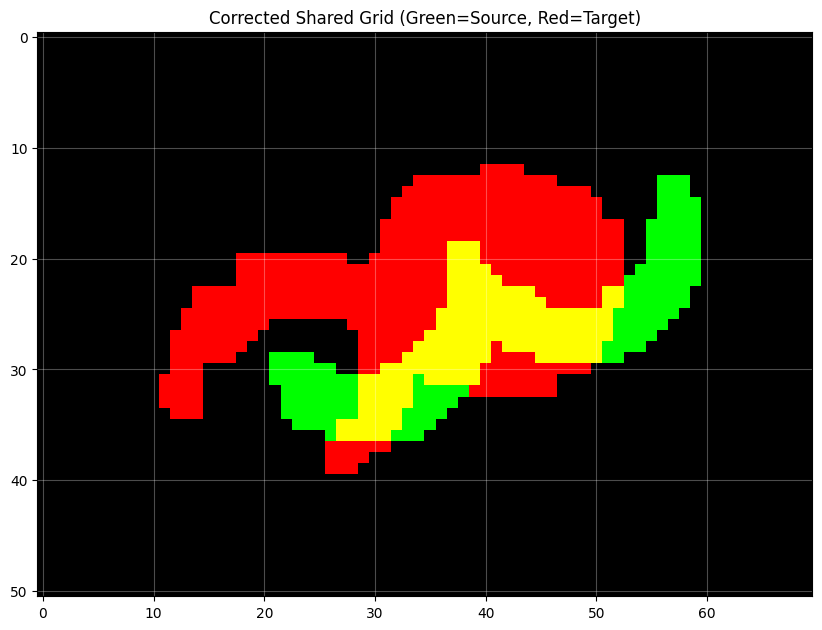

In [14]:
# --- 20. Rasterize to SHARED Grid, Clean, and Visualize ---
import cv2
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Global Setup (CRITICAL CHANGE) ---
# We calculate the bounds based on BOTH clouds so they share a coordinate system.
all_points = np.vstack((src_points_2d, tgt_points_2d))
global_min = np.min(all_points, axis=0)
global_max = np.max(all_points, axis=0)

print(f"Global Origin (Min X,Y): {global_min}")
print(f"Global Extent (Max X,Y): {global_max}")

def points_to_shared_grid(points, global_min_xy, global_max_xy, res=0.005, padding=10):
    """Converts points to a grid using a FIXED global origin."""
    # Grid dimensions depend on the global range, not the individual cloud
    range_xy = global_max_xy - global_min_xy
    grid_w = int(range_xy[0] / res) + 1 + (padding * 2)
    grid_h = int(range_xy[1] / res) + 1 + (padding * 2)
    
    grid = np.zeros((grid_h, grid_w), dtype=np.uint8)
    
    # Shift points relative to the GLOBAL min
    shifted_points = points - global_min_xy
    pixels = (shifted_points / res).astype(int)
    
    # Clip and Draw
    p_x = np.clip(pixels[:, 0] + padding, 0, grid_w - 1)
    p_y = np.clip(pixels[:, 1] + padding, 0, grid_h - 1)
    grid[p_y, p_x] = 255
    
    return grid, grid_w, grid_h, padding

# --- 2. Create Images on Shared Grid ---
resolution = 0.0051 
# We ignore the individual 'min_src'/'min_tgt' now. We only care about global_min.
img_src, w, h, padding = points_to_shared_grid(src_points_2d, global_min, global_max, resolution)
img_tgt, _, _, _       = points_to_shared_grid(tgt_points_2d, global_min, global_max, resolution)

# --- 3. Apply "Break & Isolate" Processing ---
# Parameters
kernel = np.ones((3, 3), np.uint8)
break_bridge_iterations = 1 

def process_mask(img):
    # A. Clean Noise (Opening)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # B. Break Bridges (Erosion)
    img = cv2.erode(img, kernel, iterations=break_bridge_iterations)
    
    # C. Keep Largest Object (Isolate)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        new_mask = np.zeros_like(img)
        cv2.drawContours(new_mask, [largest], -1, 255, thickness=cv2.FILLED)
        img = new_mask
        
    # D. Restore Size (Dilation)
    img = cv2.dilate(img, kernel, iterations=break_bridge_iterations)
    return img

print("Processing Source mask...")
img_src_processed = process_mask(img_src)
print("Processing Target mask...")
img_tgt_processed = process_mask(img_tgt)

# --- 4. Visualize Alignment ---
combined_img = np.zeros((h, w, 3), dtype=np.uint8)
combined_img[:, :, 2] = img_tgt_processed # Red (Target)
combined_img[:, :, 1] = img_src_processed # Green (Source)
# Yellow = Overlap

plt.figure(figsize=(10, 10))
plt.title("Corrected Shared Grid (Green=Source, Red=Target)")
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.grid(True, color='white', alpha=0.3)
plt.show()

Detecting Source Hinges (Geodesic Method)...
Detecting Target Hinges (Geodesic Method)...


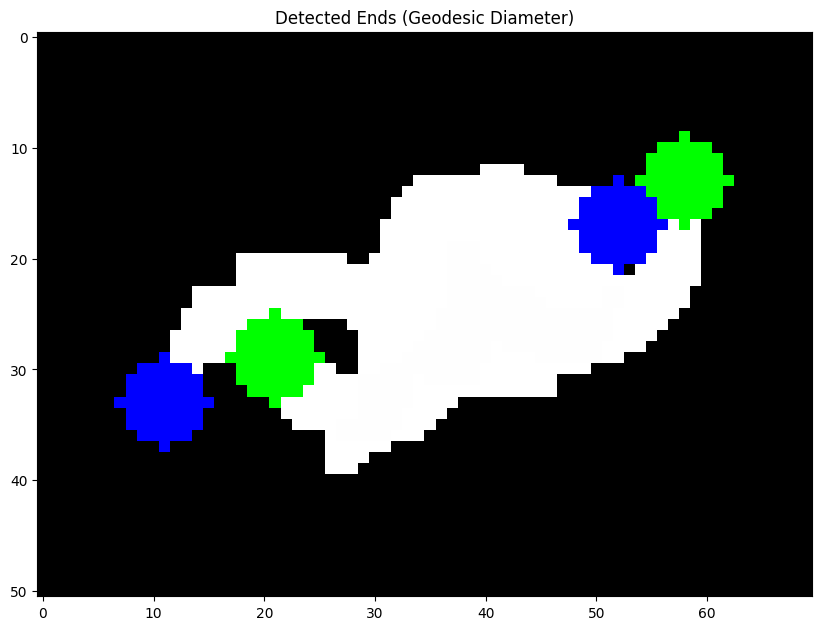

In [15]:
# --- 22. Detect Hinge Points (Geodesic BFS Method) ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def get_geodesic_ends(binary_mask, global_min, res, padding):
    """
    Finds the topological ends (tips) of a shape using Geodesic Distance.
    Algorithm: Double-BFS to find the shape's diameter.
    """
    # 1. Get all white pixel coordinates
    # Note: numpy returns (row, col) -> (y, x)
    y_idxs, x_idxs = np.where(binary_mask > 0)
    if len(y_idxs) == 0:
        return None, None
    
    # Zip into (x, y) tuples for easy processing
    all_pixels = set(zip(x_idxs, y_idxs))
    
    # Helper: Simple BFS to find furthest point
    def bfs_furthest(start_pixel):
        q = deque([start_pixel])
        visited = {start_pixel}
        last_pixel = start_pixel
        
        # Standard 4-connectivity neighbors
        moves = [(0,1), (0,-1), (1,0), (-1,0)]
        
        while q:
            cx, cy = q.popleft()
            last_pixel = (cx, cy)
            
            for dx, dy in moves:
                nx, ny = cx + dx, cy + dy
                if (nx, ny) in all_pixels and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    q.append((nx, ny))
        return last_pixel

    # 2. Step A: Pick arbitrary start point (e.g., the first one)
    # We pick a point roughly in the middle of the list to be safe
    start_node = (x_idxs[len(x_idxs)//2], y_idxs[len(y_idxs)//2])
    
    # 3. Step B: Find Tip 1 (Furthest from Start)
    tip_1_pix = bfs_furthest(start_node)
    
    # 4. Step C: Find Tip 2 (Furthest from Tip 1)
    tip_2_pix = bfs_furthest(tip_1_pix)
    
    # 5. Convert to Global Coordinates
    def pix_to_real(pix):
        # pix is (x, y)
        real_x = (pix[0] - padding) * res + global_min[0]
        real_y = (pix[1] - padding) * res + global_min[1]
        return np.array([real_x, real_y])

    hinge_1 = pix_to_real(tip_1_pix)
    hinge_2 = pix_to_real(tip_2_pix)
    
    # Return as arrays. We convert pixels to [y, x] format for OpenCV drawing if needed,
    # but matplotlib uses (x, y). Let's return (x, y) tuples for pixel coords.
    return np.array([hinge_1, hinge_2]), np.array([tip_1_pix, tip_2_pix])

# --- Execute Detection ---
try:
    print("Detecting Source Hinges (Geodesic Method)...")
    src_hinges_3d, src_hinges_pix = get_geodesic_ends(img_src_processed, global_min, resolution, padding)
    
    print("Detecting Target Hinges (Geodesic Method)...")
    tgt_hinges_3d, tgt_hinges_pix = get_geodesic_ends(img_tgt_processed, global_min, resolution, padding)

    # --- Visualization ---
    # Create RGB image for display
    debug_img = cv2.cvtColor(img_src_processed + img_tgt_processed, cv2.COLOR_GRAY2BGR)

    # Draw Source Hinges (Green)
    if src_hinges_pix is not None:
        # cv2.circle takes (x, y)
        cv2.circle(debug_img, src_hinges_pix[0], 4, (0, 255, 0), -1)
        cv2.circle(debug_img, src_hinges_pix[1], 4, (0, 255, 0), -1)

    # Draw Target Hinges (Red)
    if tgt_hinges_pix is not None:
        cv2.circle(debug_img, tgt_hinges_pix[0], 4, (0, 0, 255), -1)
        cv2.circle(debug_img, tgt_hinges_pix[1], 4, (0, 0, 255), -1)

    plt.figure(figsize=(10, 10))
    plt.title("Detected Ends (Geodesic Diameter)")
    plt.imshow(debug_img)
    plt.show()

except Exception as e:
    print(f"Error in hinge detection: {e}")
    import traceback
    traceback.print_exc()

In [16]:
# --- 24. Optimize Hinge Alignment and Move 3D Cloud (Fixed) ---
import numpy as np
import copy
import math
import open3d as o3d

def calculate_alignment_matrix(p_src, p_tgt):
    """
    Calculates the 4x4 Rigid Transformation Matrix to align two pairs of points.
    Handles 2D inputs by padding them to 3D (z=0).
    """
    # --- FIX: Ensure inputs are 3D ---
    # If points are (2,), turn them into (3,) by appending 0.0
    if p_src.shape[1] == 2:
        p_src = np.hstack((p_src, np.zeros((p_src.shape[0], 1))))
    if p_tgt.shape[1] == 2:
        p_tgt = np.hstack((p_tgt, np.zeros((p_tgt.shape[0], 1))))

    # 1. Match the pairs (Check for flipped assignment)
    # Distance A: S1->T1, S2->T2
    dist_direct = np.linalg.norm(p_src[0] - p_tgt[0]) + np.linalg.norm(p_src[1] - p_tgt[1])
    # Distance B: S1->T2, S2->T1
    dist_crossed = np.linalg.norm(p_src[0] - p_tgt[1]) + np.linalg.norm(p_src[1] - p_tgt[0])
    
    if dist_direct < dist_crossed:
        s_start, s_end = p_src[0], p_src[1]
        t_start, t_end = p_tgt[0], p_tgt[1]
    else:
        print("Swapping hinge order for better alignment...")
        s_start, s_end = p_src[0], p_src[1]
        t_start, t_end = p_tgt[1], p_tgt[0]

    # 2. Calculate Centroids (Midpoints)
    # We want to move Source Midpoint -> Target Midpoint
    c_src = (s_start + s_end) / 2.0
    c_tgt = (t_start + t_end) / 2.0
    
    # Debug print to verify shapes (Should be (3,))
    # print(f"Source Centroid shape: {c_src.shape}")

    # 3. Calculate Rotation Angle (around Z-axis)
    v_src = s_end - s_start
    v_tgt = t_end - t_start
    
    angle_src = math.atan2(v_src[1], v_src[0])
    angle_tgt = math.atan2(v_tgt[1], v_tgt[0])
    theta = angle_tgt - angle_src
    
    print(f"Aligning Centroids: {np.round(c_src, 2)} -> {np.round(c_tgt, 2)}")
    print(f"Rotating by: {np.degrees(theta):.2f} degrees")

    # 4. Construct Transformation Matrix
    # Order: Translate Source to Origin -> Rotate -> Translate to Target
    
    # T1: Translate to Origin
    T1 = np.eye(4)
    T1[0:3, 3] = -c_src # This now works because c_src is shape (3,)
    
    # R: Rotation (Z-axis)
    c, s = np.cos(theta), np.sin(theta)
    R = np.eye(4)
    R[0, 0] = c
    R[0, 1] = -s
    R[1, 0] = s
    R[1, 1] = c
    
    # T2: Translate to Target
    T2 = np.eye(4)
    T2[0:3, 3] = c_tgt
    
    # Combine: M = T2 @ R @ T1
    M = T2 @ R @ T1
    
    return M, s_start, s_end, t_start, t_end

# --- Execution ---

# 1. Calculate the Transformation
transform_matrix, s1, s2, t1, t2 = calculate_alignment_matrix(src_hinges_3d, tgt_hinges_3d)

# 2. Apply to the Source Cloud
aligned_source_cloud = copy.deepcopy(src_3d)
aligned_source_cloud.transform(transform_matrix)

# --- Visualization ---

aligned_source_cloud.paint_uniform_color([0, 1, 0]) # Green (Moved Source)
target_cloud_viz = copy.deepcopy(tgt_3d)
target_cloud_viz.paint_uniform_color([1, 0, 0])     # Red (Target)

viz_geometries = [aligned_source_cloud, target_cloud_viz]

def add_sphere(center, color, radius=0.02):
    sph = o3d.geometry.TriangleMesh.create_sphere(radius=radius)
    sph.translate(center) # Center is now guaranteed to be 3D
    sph.paint_uniform_color(color)
    sph.compute_vertex_normals()
    return sph

# Add Target Hinges (Red)
viz_geometries.append(add_sphere(t1, [0.8, 0, 0]))
viz_geometries.append(add_sphere(t2, [0.8, 0, 0]))

# Add Source Hinges (Green - Transformed)
# Note: s1/s2 are already 3D now, but they are the PRE-transform positions.
# We must apply the matrix to them to see where they land.
s1_transformed = (transform_matrix @ np.append(s1, 1))[:3]
s2_transformed = (transform_matrix @ np.append(s2, 1))[:3]

viz_geometries.append(add_sphere(s1_transformed, [0, 0.8, 0]))
viz_geometries.append(add_sphere(s2_transformed, [0, 0.8, 0]))

print("\nDisplaying optimized alignment...")
o3d.visualization.draw_geometries(viz_geometries, 
                                  window_name="Final Hinge Alignment",
                                  width=800, height=600)

Swapping hinge order for better alignment...
Aligning Centroids: [-4.71  0.07  0.  ] -> [-4.75  0.09  0.  ]
Rotating by: 2.07 degrees

Displaying optimized alignment...


Source Axis: [-0.901  0.428 -0.076]
Slicing along 0.291m length...


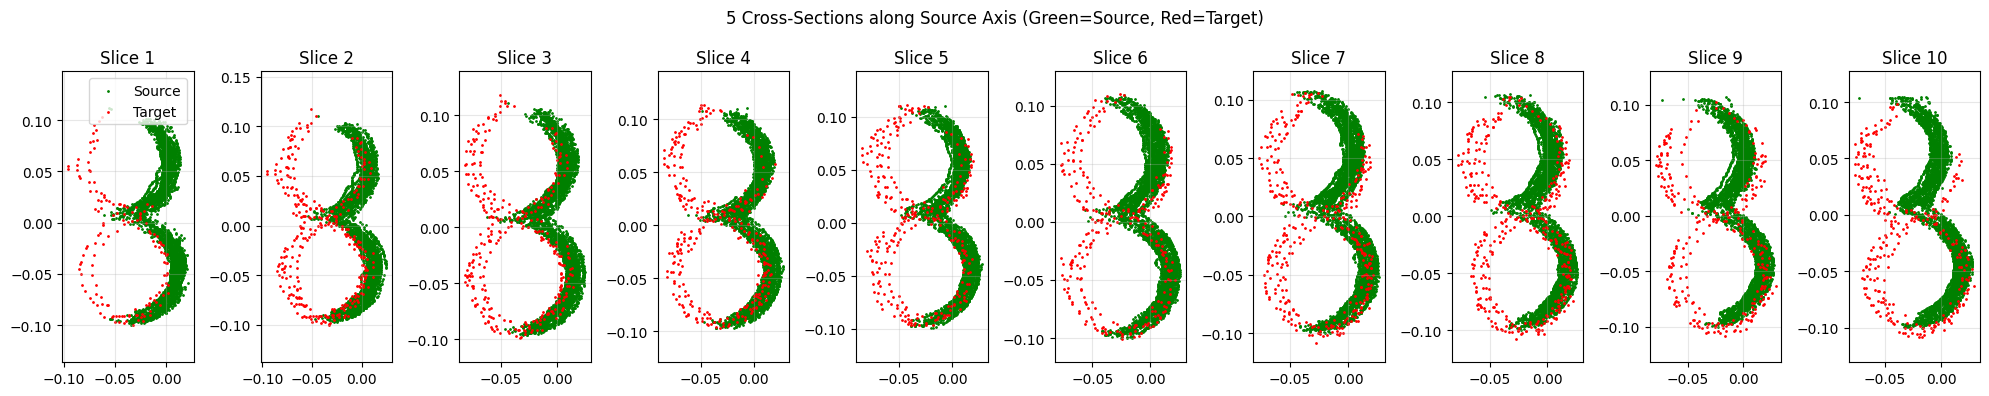

In [17]:
# --- 26. Slicing & Visualization (Plane Extension Method) ---


# --- Parameters ---
NUM_SLICES = 10
SLICE_THICKNESS = 0.05  # Thickness of the slice (meter)

# 1. Setup Clouds (Using output from Step 18)
src_work = copy.deepcopy(source_cloud)
tgt_work = copy.deepcopy(target_cloud)

pts_s = np.asarray(src_work.points)
pts_t = np.asarray(tgt_work.points)

# 2. Calculate Source Central Axis (PCA)
# We derive the "cutting rules" solely from the Source
mean_s, cov_s = src_work.compute_mean_and_covariance()
eigenvalues, eigenvectors = np.linalg.eigh(cov_s)
axis_vector = eigenvectors[:, 2] # Primary axis
axis_vector = axis_vector / np.linalg.norm(axis_vector)

print(f"Source Axis: {np.round(axis_vector, 3)}")

# 3. Establish 2D Projection Basis (u, v)
# We need a local 2D coordinate system perpendicular to the axis to plot "flat" images
# u_axis = perpendicular to axis_vector
# v_axis = perpendicular to both
world_z = np.array([0, 0, 1])
if np.abs(np.dot(axis_vector, world_z)) > 0.99: # Handle case where axis is parallel to Z
    world_z = np.array([0, 1, 0])

u_axis = np.cross(axis_vector, world_z)
u_axis = u_axis / np.linalg.norm(u_axis)
v_axis = np.cross(axis_vector, u_axis)
v_axis = v_axis / np.linalg.norm(v_axis)

# 4. Define Slice Locations
# Project source points onto axis to find the full length
vecs_s = pts_s - mean_s
projections = np.dot(vecs_s, axis_vector)
min_p, max_p = np.min(projections), np.max(projections)
total_len = max_p - min_p

# 5. Slicing Loop & Visualization
fig, axes = plt.subplots(1, NUM_SLICES, figsize=(20, 4))
fig.suptitle(f"5 Cross-Sections along Source Axis (Green=Source, Red=Target)")

print(f"Slicing along {total_len:.3f}m length...")

for i in range(NUM_SLICES):
    ax = axes[i]
    
    # Calculate Plane Center (10% to 90% along the source spine)
    dist = min_p + total_len * (0.1 + i * (0.8 / (NUM_SLICES - 1)))
    plane_center = mean_s + dist * axis_vector
    
    # --- A. Slice Source ---
    # Distance from plane = (Point - PlaneCenter) dot Normal
    dists_s = np.dot(pts_s - plane_center, axis_vector)
    mask_s = np.abs(dists_s) < (SLICE_THICKNESS / 2)
    slice_s = pts_s[mask_s]
    
    # --- B. Slice Target (Using SOURCE's Plane) ---
    # We extend the plane infinitely to catch the target, wherever it is
    dists_t = np.dot(pts_t - plane_center, axis_vector)
    mask_t = np.abs(dists_t) < (SLICE_THICKNESS / 2)
    slice_t = pts_t[mask_t]
    
    # --- C. Project to 2D (u, v) ---
    if len(slice_s) > 0:
        # u = (P - Center) dot u_axis
        # v = (P - Center) dot v_axis
        u_s = np.dot(slice_s - plane_center, u_axis)
        v_s = np.dot(slice_s - plane_center, v_axis)
        ax.scatter(u_s, v_s, c='green', s=1, label='Source')
        
    if len(slice_t) > 0:
        u_t = np.dot(slice_t - plane_center, u_axis)
        v_t = np.dot(slice_t - plane_center, v_axis)
        ax.scatter(u_t, v_t, c='red', s=1, label='Target')

    # Setup Plot
    ax.set_title(f"Slice {i+1}")
    ax.axis('equal')
    ax.grid(True, alpha=0.3)
    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

Processing 10 slices...


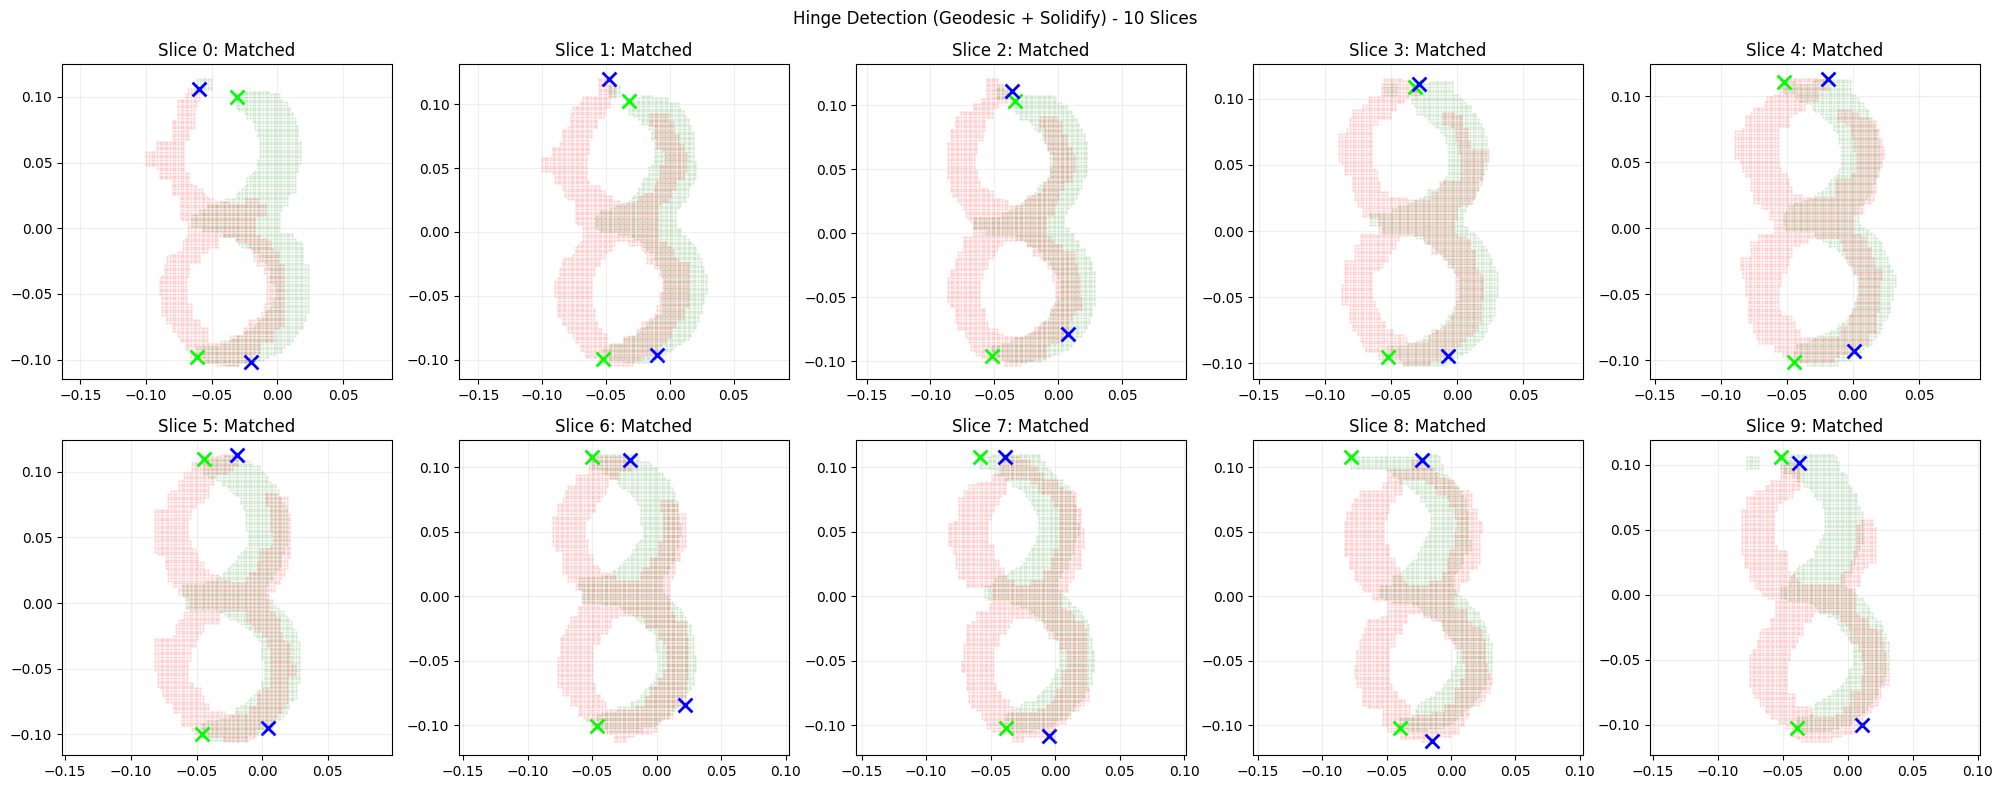

Complete. Found 10 valid slices.


In [18]:
# --- 27. Multi-Slice Geodesic Hinge Detection (Full Pipeline) ---

from collections import deque


# --- Parameters ---
NUM_SLICES = 10
SLICE_THICKNESS = 0.05
RESOLUTION = 0.002  # High Res (2mm)
PADDING = 10

# 1. Setup Clouds
# We use deepcopy to ensure we don't accidentally modify the originals during looping
src_work = copy.deepcopy(source_cloud)
tgt_work = copy.deepcopy(target_cloud)
pts_s = np.asarray(src_work.points)
pts_t = np.asarray(tgt_work.points)

# 2. Calculate Axis & Basis
# We calculate the projection basis ONCE based on the Source Cloud
mean_s, cov_s = src_work.compute_mean_and_covariance()
vals, vecs = np.linalg.eigh(cov_s)
# Use Smallest Eigenvector (Normal) to look "Face-On" (Step 19 Logic)
# If this looks wrong, swap index 0 to 2.
axis_vector = vecs[:, 2] 
axis_vector = axis_vector / np.linalg.norm(axis_vector)

# Create orthogonal basis (u, v) for the 2D plane
world_z = np.array([0, 0, 1])
if np.abs(np.dot(axis_vector, world_z)) > 0.99: world_z = np.array([0, 1, 0])
u_axis = np.cross(axis_vector, world_z); u_axis /= np.linalg.norm(u_axis)
v_axis = np.cross(axis_vector, u_axis); v_axis /= np.linalg.norm(v_axis)

# Calculate Slicing Range
projections = np.dot(pts_s - mean_s, axis_vector)
min_p, max_p = np.min(projections), np.max(projections)
total_len = max_p - min_p

# --- HELPER FUNCTIONS ---

def process_mask_solidify(img):
    """Thickens the shape to prevent 'missing half' issues."""
    kernel = np.ones((3,3), np.uint8)
    # Dilate to connect sparse points
    img = cv2.dilate(img, kernel, iterations=2)
    # Close holes
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
    return img

def get_geodesic_tips(grid):
    """Double-BFS to find topological tips."""
    y_idxs, x_idxs = np.where(grid > 0)
    if len(y_idxs) == 0: return None
    valid_pixels = set(zip(x_idxs, y_idxs))
    
    def bfs(start):
        q = deque([start]); visited = {start}; last = start
        while q:
            curr = q.popleft(); last = curr
            cx, cy = curr
            for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
                n = (cx+dx, cy+dy)
                if n in valid_pixels and n not in visited:
                    visited.add(n); q.append(n)
        return last

    start = (x_idxs[len(x_idxs)//2], y_idxs[len(y_idxs)//2])
    tip1 = bfs(start)
    tip2 = bfs(tip1)
    return [tip1, tip2]

def rasterize(points, center, res, pad):
    if len(points) < 5: return None, None
    
    # Project to 2D (u, v)
    u = np.dot(points - center, u_axis)
    v = np.dot(points - center, v_axis)
    
    # Create Grid
    min_uv = np.min(np.column_stack([u,v]), axis=0)
    pix = ((np.column_stack([u,v]) - min_uv) / res).astype(int)
    max_pix = np.max(pix, axis=0)
    
    h, w = max_pix[1]+1+2*pad, max_pix[0]+1+2*pad
    grid = np.zeros((h, w), dtype=np.uint8)
    
    # Clip and Draw
    px = np.clip(pix[:,0]+pad, 0, w-1)
    py = np.clip(pix[:,1]+pad, 0, h-1)
    grid[py, px] = 255
    
    return grid, min_uv

def pix_to_3d(pix_list, min_uv, center, res, pad):
    """Converts list of pixels back to 3D and 2D(uv) coords."""
    res_3d = []
    res_uv = []
    for p in pix_list:
        u = (p[0] - pad) * res + min_uv[0]
        v = (p[1] - pad) * res + min_uv[1]
        # 3D Reconstruct
        pt_3d = center + u*u_axis + v*v_axis
        res_3d.append(pt_3d)
        res_uv.append([u, v])
    return np.array(res_3d), np.array(res_uv)

# --- MAIN LOOP ---
slice_hinge_data = []

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()
fig.suptitle(f"Hinge Detection (Geodesic + Solidify) - {NUM_SLICES} Slices")

print(f"Processing {NUM_SLICES} slices...")

for i in range(NUM_SLICES):
    ax = axes[i]
    
    # 1. Define Slice Plane
    dist = min_p + total_len * (0.1 + i * (0.8 / (NUM_SLICES - 1)))
    plane_center = mean_s + dist * axis_vector
    
    # 2. Slice Clouds
    mask_s = np.abs(np.dot(pts_s - plane_center, axis_vector)) < (SLICE_THICKNESS/2)
    mask_t = np.abs(np.dot(pts_t - plane_center, axis_vector)) < (SLICE_THICKNESS/2)
    
    slc_s = pts_s[mask_s]
    slc_t = pts_t[mask_t]
    
    # 3. Process Source
    grid_s, min_s = rasterize(slc_s, plane_center, RESOLUTION, PADDING)
    tips_s = None
    if grid_s is not None:
        grid_s = process_mask_solidify(grid_s) # Make solid
        tips_s = get_geodesic_tips(grid_s)     # Find tips
        
        # Visualization
        # Generate background pixels for plotting
        y, x = np.where(grid_s > 0)
        uv_s_plot = []
        for j in range(len(x)):
             u = (x[j] - PADDING) * RESOLUTION + min_s[0]
             v = (y[j] - PADDING) * RESOLUTION + min_s[1]
             uv_s_plot.append([u,v])
        uv_s_plot = np.array(uv_s_plot)
        if len(uv_s_plot) > 0:
            ax.scatter(uv_s_plot[:,0], uv_s_plot[:,1], c='green', s=1, alpha=0.1)

    # 4. Process Target
    grid_t, min_t = rasterize(slc_t, plane_center, RESOLUTION, PADDING)
    tips_t = None
    if grid_t is not None:
        grid_t = process_mask_solidify(grid_t)
        tips_t = get_geodesic_tips(grid_t)
        
        # Visualization
        y, x = np.where(grid_t > 0)
        uv_t_plot = []
        for j in range(len(x)):
             u = (x[j] - PADDING) * RESOLUTION + min_t[0]
             v = (y[j] - PADDING) * RESOLUTION + min_t[1]
             uv_t_plot.append([u,v])
        uv_t_plot = np.array(uv_t_plot)
        if len(uv_t_plot) > 0:
            ax.scatter(uv_t_plot[:,0], uv_t_plot[:,1], c='red', s=1, alpha=0.1)

    # 5. Store & Plot Hinges
    h_s_3d = None
    h_t_3d = None
    
    if tips_s:
        h_s_3d, coords_s = pix_to_3d(tips_s, min_s, plane_center, RESOLUTION, PADDING)
        ax.scatter(coords_s[:,0], coords_s[:,1], c='lime', marker='x', s=100, linewidth=2)
        
    if tips_t:
        h_t_3d, coords_t = pix_to_3d(tips_t, min_t, plane_center, RESOLUTION, PADDING)
        ax.scatter(coords_t[:,0], coords_t[:,1], c='blue', marker='x', s=100, linewidth=2)
        
    if h_s_3d is not None and h_t_3d is not None:
        slice_hinge_data.append({
            'slice_id': i,
            'src': h_s_3d,
            'tgt': h_t_3d
        })
        ax.set_title(f"Slice {i}: Matched")
    else:
        ax.set_title(f"Slice {i}: Incomplete")
        
    ax.axis('equal')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

print(f"Complete. Found {len(slice_hinge_data)} valid slices.")

In [19]:
# --- 28. Align Slices, Filter Outliers, and Apply Transformation ---


# --- Helper: Calculate Alignment for a Single Slice ---
def get_slice_alignment(p_src, p_tgt):
    """
    Calculates rotation (theta) and translation to align 
    source hinges (p_src) to target hinges (p_tgt).
    Returns: theta (radians), translation (vector), transformation matrix (4x4)
    """
    # 1. Match the pairs (minimize total distance)
    # Case A: S1->T1, S2->T2
    dist_a = np.linalg.norm(p_src[0] - p_tgt[0]) + np.linalg.norm(p_src[1] - p_tgt[1])
    # Case B: S1->T2, S2->T1 (Flipped)
    dist_b = np.linalg.norm(p_src[0] - p_tgt[1]) + np.linalg.norm(p_src[1] - p_tgt[0])
    
    if dist_a < dist_b:
        s_start, s_end = p_src[0], p_src[1]
        t_start, t_end = p_tgt[0], p_tgt[1]
    else:
        s_start, s_end = p_src[0], p_src[1]
        t_start, t_end = p_tgt[1], p_tgt[0]

    # 2. Centroids
    c_src = (s_start + s_end) / 2.0
    c_tgt = (t_start + t_end) / 2.0

    # 3. Rotation (Z-axis assumed for 2D slice plane)
    # We align vector (S_end - S_start) to (T_end - T_start)
    # Note: This is 2D rotation in the slice plane.
    # Since we are in 3D, we need to be careful. 
    # However, the problem setup implies these are roughly parallel planes.
    # A robust way is to compute the translation first, then rotation.
    
    # Translation to match centroids
    translation = c_tgt - c_src
    
    # Rotation:
    # Construct local vectors
    v_src = s_end - s_start
    v_tgt = t_end - t_start
    
    # We calculate the angle between these vectors in the plane defined by them.
    # Or simply, 2D angle if we assume they lie on the projection plane.
    # Let's use the 3D vector angle formula, assuming rotation axis is the slice normal.
    # Axis of rotation is roughly the central axis (axis_vector from Step 26).
    
    # Normalize
    v_src_u = v_src / np.linalg.norm(v_src)
    v_tgt_u = v_tgt / np.linalg.norm(v_tgt)
    
    # Cross product gives axis * sin(theta)
    cross = np.cross(v_src_u, v_tgt_u)
    # Dot product gives cos(theta)
    dot = np.dot(v_src_u, v_tgt_u)
    
    # Angle
    # Clip dot product to valid range [-1, 1]
    dot = np.clip(dot, -1.0, 1.0)
    angle = np.arccos(dot)
    
    # Direction of rotation check (is cross product parallel or anti-parallel to axis?)
    # We use the pre-calculated axis_vector from Step 26/27
    if np.dot(cross, axis_vector) < 0:
        angle = -angle
        
    # Create 4x4 Matrix
    # 1. Translate Source Centroid to Origin
    T1 = np.eye(4)
    T1[0:3, 3] = -c_src
    
    # 2. Rotate around axis
    # Rodriguez rotation formula components
    K = np.array([
        [0, -axis_vector[2], axis_vector[1]],
        [axis_vector[2], 0, -axis_vector[0]],
        [-axis_vector[1], axis_vector[0], 0]
    ])
    R_mat = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * np.dot(K, K)
    
    R_4x4 = np.eye(4)
    R_4x4[0:3, 0:3] = R_mat
    
    # 3. Translate to Target Centroid
    T2 = np.eye(4)
    T2[0:3, 3] = c_tgt
    
    # Combine: M = T2 @ R @ T1
    M = T2 @ R_4x4 @ T1
    
    return angle, translation, M

# --- Main Processing ---

valid_transforms = []
translations = []
rotations = []

print(f"Calculating alignments for {len(slice_hinge_data)} valid slices...")

for item in slice_hinge_data:
    sid = item['slice_id']
    src = item['src']
    tgt = item['tgt']
    
    try:
        angle, trans, matrix = get_slice_alignment(src, tgt)
        valid_transforms.append({
            'id': sid,
            'angle': angle,
            'trans': trans,
            'matrix': matrix
        })
        translations.append(trans)
        rotations.append(angle)
        # print(f"  Slice {sid}: Rot={np.degrees(angle):.1f} deg, Trans={np.round(trans, 2)}")
    except Exception as e:
        print(f"  Slice {sid}: Failed to align ({e})")

# --- Outlier Rejection (Median Filter) ---
if not valid_transforms:
    print("Error: No valid alignments found!")
else:
    # 1. Calculate Medians
    med_trans = np.median(translations, axis=0)
    med_rot = np.median(rotations)
    
    print(f"\nMedian Translation: {np.round(med_trans, 3)}")
    print(f"Median Rotation: {np.degrees(med_rot):.2f} degrees")
    
    # 2. Filter
    # Thresholds: arbitrary but practical (e.g., distance > 2x std dev or fixed value)
    # Let's use a simple deviation check.
    # Allowed deviation: Translation 20% of magnitude or 0.05 units, Angle 15 degrees
    
    final_matrices = []
    kept_indices = []
    
    for i, t in enumerate(valid_transforms):
        d_trans = np.linalg.norm(t['trans'] - med_trans)
        d_rot = abs(t['angle'] - med_rot)
        
        # Criteria (Adjust these if too strict/loose)
        is_trans_ok = d_trans < 0.2 # Allow 20cm deviation
        is_rot_ok = np.degrees(d_rot) < 30 # Allow 30 degrees deviation
        
        if is_trans_ok and is_rot_ok:
            final_matrices.append(t['matrix'])
            kept_indices.append(t['id'])
        else:
            print(f"  Excluding Slice {t['id']}: Dev Trans={d_trans:.3f}, Dev Rot={np.degrees(d_rot):.1f} deg")

    print(f"\nkept {len(final_matrices)}/{len(valid_transforms)} slices after filtering.")

    # --- 3. Average & Apply ---
    if final_matrices:
        # Average Translations
        # Decompose matrices to get translations
        all_Ts = [m[0:3, 3] for m in final_matrices]
        avg_T = np.mean(all_Ts, axis=0)
        
        # Average Rotations
        # Averaging rotation matrices is tricky.
        # Simple approach: Average the angles and reconstruct, or use scipy if available.
        # Given we built them from axis/angle, let's average the angles again from the INLIERS.
        inlier_angles = [t['angle'] for t in valid_transforms if t['id'] in kept_indices]
        avg_angle = np.mean(inlier_angles)
        
        print(f"Final Mean Translation: {np.round(avg_T, 3)}")
        print(f"Final Mean Rotation: {np.degrees(avg_angle):.2f} degrees")
        
        # Reconstruct Final Matrix
        # Using the same logic as get_slice_alignment but with mean values
        # We need a center of rotation.
        # Warning: Averaging matrices with different pivots (T1) is mathematically complex.
        # Better approach:
        # 1. Compute the mean Translation vector (Centroid_Tgt - Centroid_Src).
        # 2. Compute the mean Rotation angle.
        # 3. Construct one global matrix using the global centroids.
        
        # Global Centroids
        c_s_global = src_work.get_center()
        # The translation we found is essentially (Tgt - Src).
        # So Final_Pos = Src + Avg_Translation
        # But we also have rotation.
        
        # Let's apply the MEAN MATRIX approach directly to the cloud points if possible,
        # or better, reconstruct a rigid transform.
        
        # Simplified Final Construction:
        # 1. Center source at origin
        T_to_origin = np.eye(4); T_to_origin[0:3, 3] = -c_s_global
        
        # 2. Rotate by avg_angle around axis_vector
        K = np.array([
            [0, -axis_vector[2], axis_vector[1]],
            [axis_vector[2], 0, -axis_vector[0]],
            [-axis_vector[1], axis_vector[0], 0]
        ])
        R_mat = np.eye(3) + np.sin(avg_angle) * K + (1 - np.cos(avg_angle)) * np.dot(K, K)
        R_4x4 = np.eye(4); R_4x4[0:3, 0:3] = R_mat
        
        # 3. Move back + Mean Translation
        # Note: The calculated translations in slices were (C_tgt - C_src).
        # So Global_Tgt = Global_Src + Avg_Trans
        T_back = np.eye(4); T_back[0:3, 3] = c_s_global + avg_T
        
        # However, rotation happens *around* the centroid.
        # If we rotate, the translation required changes.
        # Let's stick to the definition:
        # For each slice, we found M s.t. P_tgt ~ M @ P_src
        # We want M_final = Average(M_slices)
        # Averaging 4x4 matrices element-wise is not strictly valid for rigid bodies (scaling issues),
        # but for small rotations it's a decent approximation.
        # A better way is to use the Average Translation and Average Rotation we found.
        
        # Let's refine the final matrix construction:
        # We want to rotate source around its center, then translate it.
        # T_final = Translate(Global_Src + Avg_Displacement) @ Rotate(Avg_Angle) @ Translate(-Global_Src)
        
        # Wait, 'avg_T' calculated above is (Centroid_Target - Centroid_Source) for each slice.
        # It captures the displacement.
        
        final_transform = np.eye(4)
        final_transform[0:3, 3] = c_s_global + avg_T # Move to destination
        final_transform = final_transform @ R_4x4      # Rotate
        final_transform = final_transform @ T_to_origin # Move to origin
        
        # --- Apply ---
        final_source = copy.deepcopy(source_cloud)
        # To apply custom matrix constructed from components:
        # Open3D transform applies M @ P. 
        # Our logic was: Move to Origin -> Rotate -> Move to Dest
        # final_source.transform(final_transform) 
        
        # Alternative: Just apply the average matrix element-wise (safer for visualization)
        # avg_matrix = np.mean(final_matrices, axis=0)
        # final_source.transform(avg_matrix)
        
        # Let's use the constructed one as it's cleaner
        final_source.transform(final_transform)

        # --- Visualize ---
        final_source.paint_uniform_color([0, 1, 0]) # Green
        tgt_work.paint_uniform_color([1, 0, 0])     # Red
        
        print("Displaying Final Result...")
        o3d.visualization.draw_geometries([final_source, tgt_work])
        
    else:
        print("No slices remained after outlier rejection.")

Calculating alignments for 10 valid slices...

Median Translation: [ 0.014  0.028 -0.003]
Median Rotation: 10.71 degrees

kept 10/10 slices after filtering.
Final Mean Translation: [ 0.001 -0.053 -0.31 ]
Final Mean Rotation: 9.23 degrees
Displaying Final Result...


In [20]:
# --- Parameters ---
RANSAC_THRESHOLD = 0.02  # 2cm tolerance for a "match"

print(f"--- Translation-Only Optimization on {len(slice_hinge_data)} Slices ---")

# 1. Flatten and Pair Hinge Points
# We have lists of [pt1, pt2] for src and tgt. We need to ensure S1 pairs with T1, not T2.
# We use the vector between points to align orientation.
matched_src_pts = []
matched_tgt_pts = []

for item in slice_hinge_data:
    src = item['src'] # [s1, s2]
    tgt = item['tgt'] # [t1, t2]
    
    # Check orientation
    vec_s = src[1] - src[0]
    vec_t = tgt[1] - tgt[0]
    
    # If dot product is positive, they point same way (S1->T1). Else flip (S1->T2).
    if np.dot(vec_s, vec_t) > 0:
        matched_src_pts.extend([src[0], src[1]])
        matched_tgt_pts.extend([tgt[0], tgt[1]])
    else:
        matched_src_pts.extend([src[0], src[1]])
        matched_tgt_pts.extend([tgt[1], tgt[0]])

matched_src_pts = np.array(matched_src_pts)
matched_tgt_pts = np.array(matched_tgt_pts)

print(f"Total Hinge Points extracted: {len(matched_src_pts)}")

# 2. RANSAC for Translation
# We test the translation suggested by EVERY point pair and see which one explains the most points.
best_inlier_count = -1
best_inlier_indices = []
best_translation_candidate = np.array([0.0, 0.0, 0.0])

for i in range(len(matched_src_pts)):
    # Candidate Translation: T_tgt - T_src
    candidate_T = matched_tgt_pts[i] - matched_src_pts[i]
    
    # Apply this translation to ALL source points
    test_src_pos = matched_src_pts + candidate_T
    
    # Calculate errors (distances) to targets
    errors = np.linalg.norm(test_src_pos - matched_tgt_pts, axis=1)
    
    # Find inliers
    inlier_mask = errors < RANSAC_THRESHOLD
    inlier_count = np.sum(inlier_mask)
    
    # Save if this is the best model so far
    if inlier_count > best_inlier_count:
        best_inlier_count = inlier_count
        best_inlier_indices = np.where(inlier_mask)[0]
        best_translation_candidate = candidate_T

# 3. Refine Translation (Average of Inliers)
# Using only the "good" matches to smooth out jitter
if len(best_inlier_indices) > 0:
    # Get the specific translations required for all inliers
    inlier_diffs = matched_tgt_pts[best_inlier_indices] - matched_src_pts[best_inlier_indices]
    final_translation = np.mean(inlier_diffs, axis=0)
    
    print(f"\nOptimization Complete:")
    print(f"  - Matched Inliers: {best_inlier_count}/{len(matched_src_pts)}")
    print(f"  - Optimal Translation: {np.round(final_translation, 4)}")
else:
    print("Warning: No good matches found. Using zero translation.")
    final_translation = np.array([0.0, 0.0, 0.0])

# 4. Create Transformation Matrix (No Rotation)
final_matrix = np.eye(4)
final_matrix[0:3, 3] = final_translation

print("\nFinal Transformation Matrix (Translation Only):")
print(final_matrix)

# 5. Apply Transformation
final_source = copy.deepcopy(source_cloud)
final_source.transform(final_matrix)

# 6. Visualization
final_source.paint_uniform_color([0, 1, 0]) # Green
tgt_work = copy.deepcopy(target_cloud)
tgt_work.paint_uniform_color([1, 0, 0])     # Red

# Visualize Hinge Points for verification
vis_elements = [final_source, tgt_work]

# Add spheres for inlier hinges to confirm alignment
for idx in best_inlier_indices:
    # Target point (Red sphere)
    sph_t = o3d.geometry.TriangleMesh.create_sphere(radius=0.015)
    sph_t.translate(matched_tgt_pts[idx])
    sph_t.paint_uniform_color([1, 0, 0])
    
    # Transformed Source point (Green sphere)
    sph_s = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
    # We take original source and apply final matrix
    pt_s_transformed = matched_src_pts[idx] + final_translation
    sph_s.translate(pt_s_transformed)
    sph_s.paint_uniform_color([0, 1, 0])
    
    vis_elements.append(sph_t)
    vis_elements.append(sph_s)

print("\nDisplaying Result (Green=Moved Source, Red=Target, Spheres=Matched Hinges)...")
o3d.visualization.draw_geometries(vis_elements, 
                                  window_name="Translation-Only Hinge Alignment",
                                  width=1024, height=768)

--- Translation-Only Optimization on 10 Slices ---
Total Hinge Points extracted: 20

Optimization Complete:
  - Matched Inliers: 12/20
  - Optimal Translation: [ 0.017   0.0359 -0.0001]

Final Transformation Matrix (Translation Only):
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  1.70331335e-02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  3.58700561e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -6.64863741e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Displaying Result (Green=Moved Source, Red=Target, Spheres=Matched Hinges)...
